# Predict with future weather

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
#ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_future/scenario_ref.csv')
w = calc_cumulative_weather(w)

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 
gs_agg = gs_agg.drop('water_temp_mean', axis='columns')

In [8]:
gs_agg[gs_agg.isna().any(axis=1)]
gs_agg = gs_agg.dropna()
gs_agg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 212 entries, 0 to 213
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   station_id                  212 non-null    int64          
 1   x                           212 non-null    float64        
 2   y                           212 non-null    float64        
 3   start_date                  212 non-null    datetime64[ns] 
 4   end_date                    212 non-null    datetime64[ns] 
 5   ground_elev                 212 non-null    float64        
 6   measure_elev                212 non-null    float64        
 7   lifespan                    212 non-null    timedelta64[ns]
 8   geometry                    212 non-null    geometry       
 9   water_level_mean            212 non-null    float64        
 10  water_depth_mean            212 non-null    float64        
 11  ini_years_water_depth_mean  212 non-null  

### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [6]:
#explore_clusters(gs_agg[['x', 'y']])

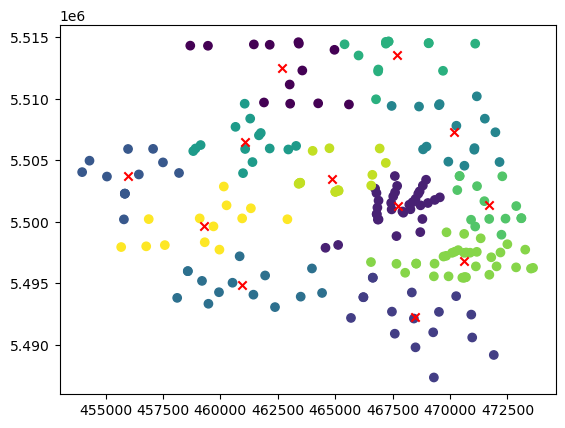

In [9]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [10]:
m = gs_agg.merge(w, how='cross')

,station_id,x,y,start_date,end_date,ground_elev,measure_elev,lifespan,geometry,water_level_mean,...,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
0,12890,458821.0,5505747.0,1969-01-01,2010-08-18,87.44,87.95,15204 days,POINT (8.42892 49.70283),85.754006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12890,458821.0,5505747.0,1969-01-01,2010-08-18,87.44,87.95,15204 days,POINT (8.42892 49.70283),85.754006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12890,458821.0,5505747.0,1969-01-01,2010-08-18,87.44,87.95,15204 days,POINT (8.42892 49.70283),85.754006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12890,458821.0,5505747.0,1969-01-01,2010-08-18,87.44,87.95,15204 days,POINT (8.42892 49.70283),85.754006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12890,458821.0,5505747.0,1969-01-01,2010-08-18,87.44,87.95,15204 days,POINT (8.42892 49.70283),85.754006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871751,17131,469267.0,5491023.0,2013-01-01,2024-03-01,97.56,98.24,4077 days,POINT (8.57494 49.57102),93.756667,...,11.474194,2.629732,65.577858,2.802991,191.044264,6.101146,717.297607,10.088185,2163.941624,10.086182
3871752,17131,469267.0,5491023.0,2013-01-01,2024-03-01,97.56,98.24,4077 days,POINT (8.57494 49.57102),93.756667,...,11.375057,2.555825,65.028531,2.746693,191.427840,5.981810,717.881805,10.087599,2162.671815,10.086571
3871753,17131,469267.0,5491023.0,2013-01-01,2024-03-01,97.56,98.24,4077 days,POINT (8.57494 49.57102),93.756667,...,13.247698,2.504748,66.437109,2.699935,192.765762,5.855063,718.532709,10.086741,2162.823759,10.087248
3871754,17131,469267.0,5491023.0,2013-01-01,2024-03-01,97.56,98.24,4077 days,POINT (8.57494 49.57102),93.756667,...,12.555622,2.305799,64.344789,2.678914,188.194761,5.733481,718.796172,10.090060,2162.282121,10.087529


In [11]:
m.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3871756 entries, 0 to 3871755
Data columns (total 34 columns):
 #   Column                      Dtype          
---  ------                      -----          
 0   station_id                  int64          
 1   x                           float64        
 2   y                           float64        
 3   start_date                  datetime64[ns] 
 4   end_date                    datetime64[ns] 
 5   ground_elev                 float64        
 6   measure_elev                float64        
 7   lifespan                    timedelta64[ns]
 8   geometry                    geometry       
 9   water_level_mean            float64        
 10  water_depth_mean            float64        
 11  ini_years_water_depth_mean  float64        
 12  ini_years_water_depth_std   float64        
 13  ini_years_water_depth_min   float64        
 14  ini_years_water_depth_max   float64        
 15  reg_clusters                int32        

# todo: merge dfs properly and make them identical to training 

In [8]:
g_merged = merge_groundwater_data(g, gs_agg)
#g_merged.describe()

In [9]:
#g_merged.head()

In [10]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

In [11]:
m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 557260 entries, 1912-10-15 to 2024-03-20
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   station_id                  557260 non-null  int64          
 1   date                        557260 non-null  datetime64[ns] 
 2   water_dist                  554273 non-null  float64        
 3   water_level                 554273 non-null  float64        
 4   water_depth                 554273 non-null  float64        
 5   water_temp                  66890 non-null   float64        
 6   x                           557260 non-null  float64        
 7   y                           557260 non-null  float64        
 8   start_date                  557260 non-null  datetime64[ns] 
 9   end_date                    557260 non-null  datetime64[ns] 
 10  ground_elev                 557260 non-null  float64        
 11  measure_el

In [12]:
m.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
count,557260.000000,557260,554273.000000,554273.000000,554273.000000,66890.00000,557260.000000,5.572600e+05,557260,557260,...,261778.000000,261778.000000,261319.000000,261319.000000,259943.000000,259943.000000,253937.000000,253937.000000,237770.000000,237770.000000
mean,13589.102144,1995-03-01 05:35:27.078921856,3.594004,89.469690,3.220631,12.27388,465759.276823,5.501905e+06,1966-12-22 22:03:30.291784816,2017-11-11 00:57:30.511431168,...,13.553365,10.094269,58.092607,10.104721,174.390739,10.135471,706.887209,10.103328,2118.915731,10.101306
min,12890.000000,1912-10-15 00:00:00,0.000000,81.140000,-0.870000,2.02000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,3.179936,0.232753,33.786290,1.179873,136.134168,2.017988,668.570977,10.017296,2057.468638,10.071740
25%,13157.000000,1980-08-25 00:00:00,2.500000,86.900000,2.100000,11.30000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,10.899160,3.296927,51.265472,3.526549,161.107638,4.368666,697.380704,10.086928,2105.620456,10.090351
50%,13568.000000,1997-12-01 00:00:00,3.360000,89.240000,3.030000,12.00000,466857.965000,5.501588e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,13.076597,9.207563,57.330948,9.624721,174.569748,9.990525,707.334770,10.104048,2117.647835,10.101510
75%,13774.000000,2013-08-22 00:00:00,4.400000,92.090000,4.040000,12.90000,469927.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,15.778340,16.305345,64.509759,16.150012,186.347288,15.939850,715.736084,10.122640,2130.475141,10.108813
max,17794.000000,2024-03-20 00:00:00,11.160000,96.270000,10.790000,21.30000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,31.068251,20.618877,94.414325,19.859505,226.707239,18.575481,747.384501,10.175205,2177.794176,10.139199
std,609.112889,NaN,1.527469,3.005891,1.476485,1.55057,4829.443303,6.203696e+03,NaN,NaN,...,3.776524,6.436346,9.090525,6.353987,17.470859,5.784471,13.453420,0.026492,21.256684,0.014132


### Prepare data

In [13]:
m.columns.unique()

Index(['station_id', 'date', 'water_dist', 'water_level', 'water_depth',
       'water_temp', 'x', 'y', 'start_date', 'end_date', 'ground_elev',
       'measure_elev', 'lifespan', 'geometry', 'water_level_mean',
       'water_depth_mean', 'water_temp_mean', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'reg_clusters', 'water_depth_anomaly',
       'precip_mean', 'moisture_mean', 'tmean_mean', 'precip_std',
       'moisture_std', 'tmean_std', 'precip_mean_prev_2d_sum',
       'tmean_mean_prev_2d_mean', 'precip_mean_prev_7d_sum',
       'tmean_mean_prev_7d_mean', 'precip_mean_prev_30d_sum',
       'tmean_mean_prev_30d_mean', 'precip_mean_prev_90d_sum',
       'tmean_mean_prev_90d_mean', 'precip_mean_prev_1y_sum',
       'tmean_mean_prev_1y_mean', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_3y_mean'],
      dtype='object')

In [14]:
# restrict data to these columns
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
#df.info()

In [15]:
#df[df.isna().any(axis=1)]

In [16]:
df = df.dropna()
df

,station_id,date,water_depth,ground_elev,x,y,geometry,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
2002-12-30,13595,2002-12-30,7.36,98.21,468527.000,5496600.000,POINT (8.56426 49.62114),0,8.522269,0.768206,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,13596,2002-12-30,1.77,96.18,469327.000,5496600.000,POINT (8.57533 49.62118),0,3.236500,0.308402,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,13597,2002-12-30,5.76,99.38,468527.000,5496610.000,POINT (8.56426 49.62123),0,7.300654,0.235319,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,13601,2002-12-30,3.19,94.77,466558.000,5496730.000,POINT (8.53699 49.62220),6,2.848099,0.241916,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,13612,2002-12-30,0.55,95.17,471796.000,5497120.000,POINT (8.60948 49.62598),0,1.227816,0.517872,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-20,13488,2024-03-20,3.48,91.11,460950.315,5500278.990,POINT (8.45900 49.65379),2,2.724809,0.158636,...,47.774662,147.862182,715.033979,2158.827072,5.253660,6.101060,4.565436,2.668046,10.090526,10.120871
2024-03-20,13832,2024-03-20,1.70,93.71,470626.000,5504557.000,POINT (8.59272 49.69282),4,2.002682,0.277334,...,47.774662,147.862182,715.033979,2158.827072,5.253660,6.101060,4.565436,2.668046,10.090526,10.120871
2024-03-20,13836,2024-03-20,7.83,99.92,472156.000,5504857.000,POINT (8.61391 49.69559),4,8.537297,0.555361,...,47.774662,147.862182,715.033979,2158.827072,5.253660,6.101060,4.565436,2.668046,10.090526,10.120871


In [17]:
reserve_cols_as_info = ['station_id', 'date', 'geometry']
    
info = df[reserve_cols_as_info].copy()

X = df.copy().drop(reserve_cols_as_info, axis=1)

## Unpickle model

In [18]:
# load model
if True:
    name = 'HGBoost'
    
    with open(f'./models/{name}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    model#.best_params_

## Predict groundwater levels

In [19]:
y_pred = pd.DataFrame(model.predict(X), columns=['pred_water_depth'])
y_pred.index = info.index
y_pred.head()

,pred_water_depth
date,
2002-12-30,8.381529
2002-12-30,3.103814
2002-12-30,7.154739
2002-12-30,4.372603
2002-12-30,1.553907


In [20]:
X.head()

,water_depth,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
2002-12-30,7.36,98.21,468527.0,5496600.0,0,8.522269,0.768206,7.05,9.65,3.338097,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,1.77,96.18,469327.0,5496600.0,0,3.236500,0.308402,2.40,3.77,3.338097,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,5.76,99.38,468527.0,5496610.0,0,7.300654,0.235319,6.90,7.70,3.338097,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,3.19,94.77,466558.0,5496730.0,6,2.848099,0.241916,2.46,3.60,3.338097,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806
2002-12-30,0.55,95.17,471796.0,5497120.0,0,1.227816,0.517872,0.22,2.11,3.338097,...,66.574373,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806


In [21]:
info.head()

,station_id,date,geometry
date,,,
2002-12-30,13595,2002-12-30,POINT (8.56426 49.62114)
2002-12-30,13596,2002-12-30,POINT (8.57533 49.62118)
2002-12-30,13597,2002-12-30,POINT (8.56426 49.62123)
2002-12-30,13601,2002-12-30,POINT (8.53699 49.62220)
2002-12-30,13612,2002-12-30,POINT (8.60948 49.62598)


In [22]:
pred = pd.concat([info, X, y_pred], axis='columns')
pred.head()

,station_id,date,geometry,water_depth,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,...,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,pred_water_depth
date,,,,,,,,,,,,,,,,,,,,,
2002-12-30,13595,2002-12-30,POINT (8.56426 49.62114),7.36,98.21,468527.0,5496600.0,0,8.522269,0.768206,...,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806,8.381529
2002-12-30,13596,2002-12-30,POINT (8.57533 49.62118),1.77,96.18,469327.0,5496600.0,0,3.236500,0.308402,...,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806,3.103814
2002-12-30,13597,2002-12-30,POINT (8.56426 49.62123),5.76,99.38,468527.0,5496610.0,0,7.300654,0.235319,...,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806,7.154739
2002-12-30,13601,2002-12-30,POINT (8.53699 49.62220),3.19,94.77,466558.0,5496730.0,6,2.848099,0.241916,...,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806,4.372603
2002-12-30,13612,2002-12-30,POINT (8.60948 49.62598),0.55,95.17,471796.0,5497120.0,0,1.227816,0.517872,...,191.573737,706.413838,2114.875138,1.500932,2.241021,2.598587,5.711319,10.093186,10.105806,1.553907


## Analyse prediction

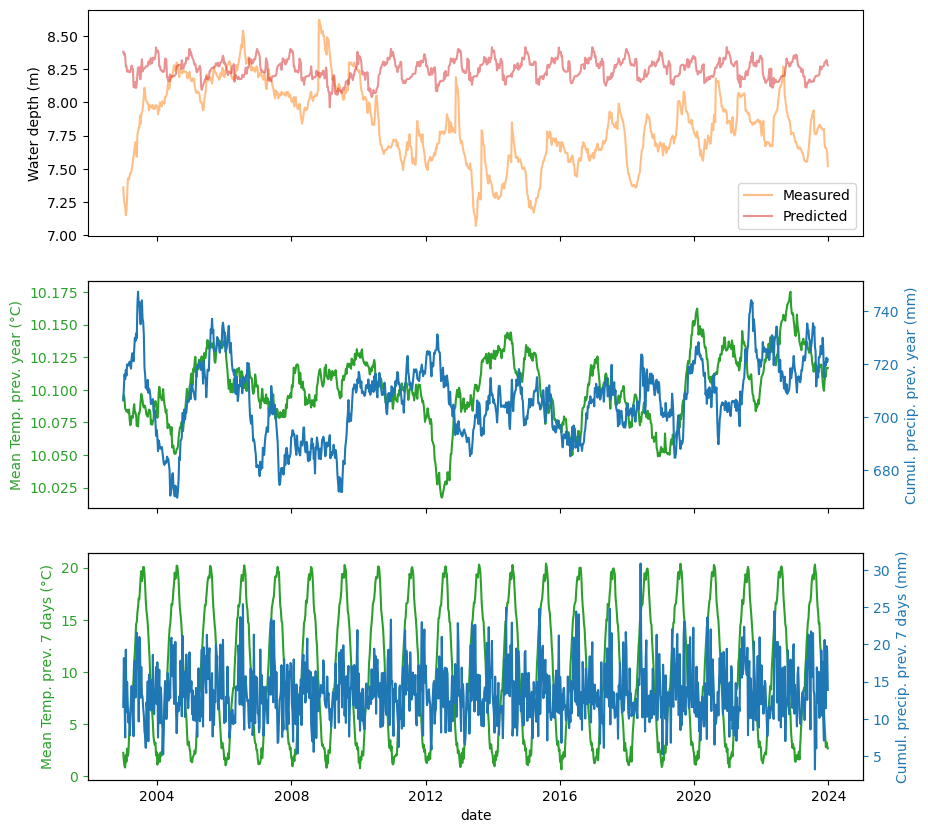

In [25]:
data = pred.loc[pred.station_id == pred.station_id.unique()[0]]

plot_predicted_data(data,
                  #pd.to_datetime('1958-01-01'), pd.to_datetime('1963-01-10'),
                  #pd.to_datetime('2010-01-01'), pd.to_datetime('2020-01-10')
                  #save=True
                 )

#plt.savefig('./figs/test.png', bbox_inches='tight')